In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Input
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.optimizers import Adam


from glob import glob

Using TensorFlow backend.


['cats_dogs/datasets/train\\cats\\cat001.jpg', 'cats_dogs/datasets/train\\cats\\cat002.jpg', 'cats_dogs/datasets/train\\cats\\cat003.jpg', 'cats_dogs/datasets/train\\cats\\cat004.jpg', 'cats_dogs/datasets/train\\cats\\cat005.jpg']
2402
600


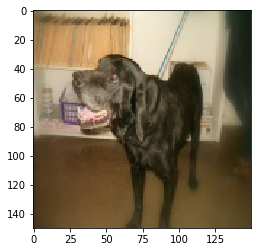

In [2]:
#Image Information
image_size = [150,150]

#Training Information
epochs = 15
batch_size = 32

train_path = "cats_dogs/datasets/train"
valid_path = "cats_dogs/datasets/validation"
#print(train_path)

#glob returns a list with the file names(their path too) present on the path * this(*) can be used in order to extract the number of training examples
image_file_names = glob(train_path + '/*/*.jp*g') #*works like an autocomplete first one is for the class name second is for the picture names and the third is in order to extract both jpg and jpeg
valid_image_file_names = glob(valid_path + "/*/*.jp*g")

folders = glob(train_path + '/*') #returns a list with the folder names. These names are the names of the different classes *this way we can find the number of classes we have
print(image_file_names[0:5]) #they contain the whole file path until the image
print(len(image_file_names))
print(len(valid_image_file_names))

#show an image
plt.imshow(image.load_img(np.random.choice(image_file_names)))
plt.show()

In [3]:
#Image Data Generators are used for data augmentations

# gen is like a class 
gen = ImageDataGenerator(
  rotation_range=45,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=False,
  #rescale=1./255, NEVER RESCALE WITH VGG PREPROCESS
  preprocessing_function=preprocess_input,  
  fill_mode = 'nearest')         # uses the fill mode nearest to fill gaps created by the above


# gen is like a class 
gen_test = ImageDataGenerator(
  #rescale=1./255, NEVER RESCALE WITH VGG PREPROCESS
  preprocessing_function=preprocess_input) #its good to check for the max value not insert it manually
#fill_mode = 'nearest')         # uses the fill mode nearest to fill gaps created by the above

In [4]:
# get label mapping for confusion matrix plot later 
test_gen = gen.flow_from_directory(train_path, target_size=image_size)  #we define the directory where it will extract its data 
print(test_gen.class_indices) #returns the class labels and their corresponding number

labels = [None] * len(test_gen.class_indices)  #[1]*2 -->[1 1] same happens for None
print(len(labels))
for k, v in test_gen.class_indices.items():  #items --> (class name, class number)
  labels[v] = k #we input the number in labels and get the output

Found 2402 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2


In [5]:
print(test_gen.class_indices) #class_indices is a dictionary, contains the class names and their numbers(encoding)
print(test_gen.class_indices.items())#items --> (class name, class number)
#print(test_gen.class_indices.items()[0]) error #need to be extracted with for like the labels above
print(type(test_gen.class_indices))
print(type(test_gen.class_indices.items()))

{'cats': 0, 'dogs': 1}
dict_items([('cats', 0), ('dogs', 1)])
<class 'dict'>
<class 'dict_items'>


(32, 150, 150, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



(32, 2)
(150, 150, 3)
min: -101.96401 max: 151.061


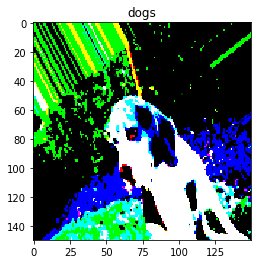

In [6]:
for x, y in test_gen: #test_gen returns tupples x--> input data y-->label it is a generator
  print(x.shape)  #tr examples=batch size, height,width, channels
  print(y.shape)  #2=no of classes
  print(x[0].shape) #one image
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])]) #labels was created by us and it contains the class name in the corresponding position (number)
  plt.imshow(x[0])
  plt.show()
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>
(32, 150, 150, 3)
(32, 2)
(150, 150, 3)
[1. 0.]


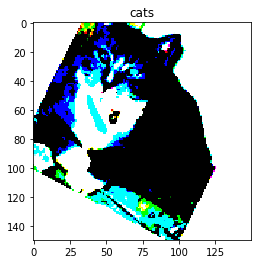

In [7]:
temp2,templabel = test_gen[1]  #test_gen returns a tupple with contains the data and the corresponding label (its number)
print(type(temp2))
print(temp2.shape)
print(templabel.shape) #32 is the default batch size, each time the generator sends a batch of 32(default)
print(temp2[0].shape) #we extract the first photo
print(templabel[0]) #we have one hot encoding
plt.title(labels[np.argmax(templabel[0])]) #labels was created by us and it contains the class name in the corresponding position (number)
plt.imshow(temp2[0])
plt.show()

In [8]:
#We create the generators that will be used to data augment and preprocess our data

train_generator = gen.flow_from_directory( # It should contain one subdirectory per class  the labels for each data are created from the subfolder name
  train_path, #it will extract all the data from here, doesnt matter if they are inside the folders 
  target_size=image_size, #height width
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=image_size, #height width
  shuffle=True,
  batch_size=batch_size,
)

Found 2402 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [9]:
#Neural Network Architecture

vgg = VGG16(input_shape = image_size +[3], weights = "imagenet", include_top = False) #weights initialized on imagenet, the 2fc layers and the softmax layer are dropped 

vgg.summary()#check the  trainable parameters at the bottom    

for layer in vgg.layers:
    layer.trainable = False #we define all the previous layers as non trainable

vgg.summary() #check the non trainable parameters at the bottom     

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [10]:
print(vgg.output.shape) #(?, 4, 4, 512)
no_classes = 2 #or len(folders)

#Flattening
x = Flatten()(vgg.output) #output needs to be flattened in order to be fed at the fc layers, output dimensions are mentioned above

#Fully Connected Layers
x = Dense(units=2048)(x) #128 neurons
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)#Dropout probability to drop a neuron #Dropout is added after the activation
x = Dense(units=2048)(x) #128 neurons
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)#Dropout probability to drop a neuron #Dropout is added after the activation
x = Dense(units=no_classes)(x)#Where k is the no classes


prediction = Activation('softmax')(x) #Here on the contrary with tensorflow we have to manually add the softmax layer

(?, 4, 4, 512)


In [11]:
#We initialize our keras model (functional api)

model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [12]:
#We compile our model
adam = Adam(lr=0.001) #default is 0.001

model.compile(loss ='categorical_crossentropy', #needs one hot encoding
             optimizer = adam,
             metrics = ["accuracy"])

In [13]:
#fit  #keras has a special fit function that takes as an input the generators
                                                                                                                     
r = model.fit_generator(train_generator, validation_data = valid_generator, epochs = epochs,
                        steps_per_epoch = len(image_file_names)//batch_size, #// rounds the result
                        validation_steps = len(valid_image_file_names)//batch_size,
                       )
# r contains the results not the model itself

Epoch 1/15
75/75 [==============================] - 16s 213ms/step - loss: 0.5315 - acc: 0.8846 - val_loss: 0.2689 - val_acc: 0.9462
Epoch 2/15
75/75 [==============================] - 16s 208ms/step - loss: 0.1944 - acc: 0.9233 - val_loss: 0.0955 - val_acc: 0.9736
Epoch 3/15
75/75 [==============================] - 15s 205ms/step - loss: 0.1696 - acc: 0.9237 - val_loss: 0.1109 - val_acc: 0.9560
Epoch 4/15
75/75 [==============================] - 15s 200ms/step - loss: 0.2515 - acc: 0.9247 - val_loss: 0.1428 - val_acc: 0.9419
Epoch 5/15
75/75 [==============================] - 15s 197ms/step - loss: 0.2099 - acc: 0.9322 - val_loss: 0.0662 - val_acc: 0.9701
Epoch 6/15
75/75 [==============================] - 15s 207ms/step - loss: 0.1404 - acc: 0.9392 - val_loss: 0.0617 - val_acc: 0.9736
Epoch 7/15
75/75 [==============================] - 15s 206ms/step - loss: 0.2160 - acc: 0.9363 - val_loss: 0.0623 - val_acc: 0.9806
Epoch 8/15
75/75 [==============================] - 15s 197ms/step - 

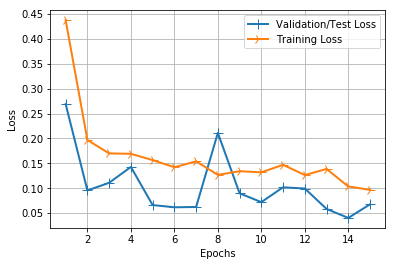

In [14]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = r.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

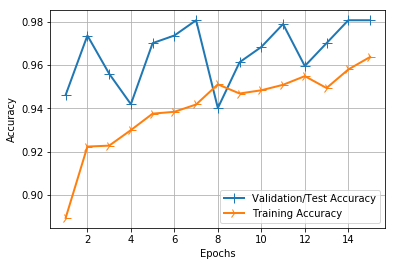

In [15]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = r.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
#Model saving

model.save("vgg16_dogsvscats_classifier.h5")
print("Model Saved")

Model Saved
